![clothing_classification](clothing_classification.png)


Fashion Forward is a new AI-based e-commerce clothing retailer.
They want to use image classification to automatically categorize new product listings, making it easier for customers to find what they're looking for. It will also assist in inventory management by quickly sorting items.

As a data scientist tasked with implementing a garment classifier, your primary objective is to develop a machine learning model capable of accurately categorizing images of clothing items into distinct garment types such as shirts, trousers, shoes, etc.

In [1]:
# Run the cells below first

In [2]:
!pip install torchmetrics
!pip install torchvision
!pip install torch

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy, Precision, Recall

In [4]:
# Load datasets
from torchvision import datasets
import torchvision.transforms as transforms

train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 26421880/26421880 [00:02<00:00, 11306417.18it/s]


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 274904.25it/s]


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4623196.47it/s]


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<00:00, 5147145.89it/s]

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



In [5]:
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
# Get the number of classes to train for

classes = train_data.classes
print(classes)
num_classes = len(train_data.classes)
print(num_classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
10


In [7]:
num_input_channels = 1
num_output_channels = 20
image_size = train_data[0][0].shape[1]
print(image_size)

28


In [8]:
# Define neural network
class MultiClassImageClassifier(nn.Module):
    def __init__(self, num_classes):
        super(MultiClassImageClassifier, self).__init__()
        # Convolution Layer
        self.conv1 = nn.Conv2d(num_input_channels, num_output_channels, kernel_size=3, stride=1, padding=1)
        # ReLU Layer (does not change output size)
        self.relu = nn.ReLU()
        # MaxPooling Layer (output size decreases to 1/2 in both dimensions)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Flattening (output flattens out into vector)
        self.flatten = nn.Flatten()

        # Fully connected layer
        self.linear = nn.Linear(num_output_channels * (image_size//2)**2, num_classes)
        
    def forward(self, x):
        # Forward pass of input through each layer
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x
      

In [9]:
# Define DataLoader for the training set
dataloader_train = DataLoader(train_data, batch_size=int(len(train_data)/1000), shuffle=True)

In [10]:
# Define function for training the model (takes optimizer, neural network and number of epochs)
def train_model(optimizer, net, num_epochs):

    num_processed = 0
    criterion = nn.CrossEntropyLoss() # Good for multi-classification problems

    losses_list = []
    # Begin training loop (backward pass)
    for epoch in range(num_epochs):
        running_loss = 0
        num_processed = 0

        for features, labels in dataloader_train:
            optimizer.zero_grad() # Set all gradients to zero
            outputs = net(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            num_processed += len(labels)
        print(f'Epoch Number {epoch}: Loss encountered {running_loss / num_processed}')
        losses_list.append(running_loss / num_processed)
        
    train_loss = running_loss / len(dataloader_train)
    
    plt.plot(losses_list)
    plt.show()
    
    return train_loss

In [11]:
# Initiate object of neural net
net = MultiClassImageClassifier(num_classes)
net.train()

# Initiate optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

Epoch Number 0: Loss encountered 0.00798813168257475
Epoch Number 1: Loss encountered 0.005670322870711486
Epoch Number 2: Loss encountered 0.005058301276092728
Epoch Number 3: Loss encountered 0.004685223965470989
Epoch Number 4: Loss encountered 0.004393247188379367
Epoch Number 5: Loss encountered 0.004172682121396065
Epoch Number 6: Loss encountered 0.003962625311439236
Epoch Number 7: Loss encountered 0.00376431812706093
Epoch Number 8: Loss encountered 0.0036583243578672407
Epoch Number 9: Loss encountered 0.0035251222406203547
Epoch Number 10: Loss encountered 0.0034056157076731326
Epoch Number 11: Loss encountered 0.0032853074494749307
Epoch Number 12: Loss encountered 0.0032343290162893633
Epoch Number 13: Loss encountered 0.003099426632001996
Epoch Number 14: Loss encountered 0.0030211369916796683
Epoch Number 15: Loss encountered 0.0029261018766711154
Epoch Number 16: Loss encountered 0.002857282945762078
Epoch Number 17: Loss encountered 0.0027943587863196928
Epoch Number 1

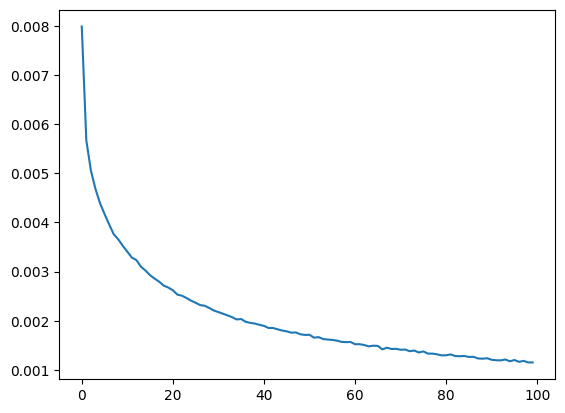

0.0690604402963072

In [12]:
# Train model for num_epochs --> 100
train_model(optimizer=optimizer, net=net, num_epochs=100)

In [16]:
# Making dataloader for my test_data
dataloader_test = DataLoader(test_data, batch_size=int(len(test_data)/1000), shuffle=True)
                             
# Defining the scores to use
acc = Accuracy(task='multiclass', num_classes=num_classes)
prec = Precision(task='multiclass', num_classes=num_classes, average=None)
recall = Recall(task='multiclass', num_classes=num_classes, average=None)

In [17]:
# Running my model on test set
net.eval() # Set to evaluation mode

predicted = []
for i, (features, labels) in enumerate(dataloader_test):
    output = net.forward(features.reshape(-1, 1, image_size, image_size)) # Running forward pass
    pred = torch.argmax(output, dim=-1)
    predicted.extend(pred.tolist())
    # Getting scores
    acc(pred, labels)
    prec(pred, labels)
    recall(pred, labels)

In [18]:
# Compute all scores
accuracy = acc.compute().item()
precision = prec.compute().tolist()
recal = recall.compute().tolist()
print('Model Accuracy:', accuracy)
print('Model Precision (per class):', precision)
print('Model Precision (average):', sum(precision)/(num_classes))
print('Model Recall (per class):', recal)
print('Model Recall (average):', sum(recal)/num_classes)

Model Accuracy: 0.900600016117096
Model Precision (per class): [0.8563995957374573, 0.9849246144294739, 0.8214285969734192, 0.8972533345222473, 0.8315585851669312, 0.9797775745391846, 0.730030357837677, 0.9560117125511169, 0.9750000238418579, 0.975782036781311]
Model Precision (average): 0.9008166432380676
Model Recall (per class): [0.8230000138282776, 0.9800000190734863, 0.8510000109672546, 0.8820000290870667, 0.859000027179718, 0.968999981880188, 0.722000002861023, 0.9779999852180481, 0.9750000238418579, 0.9670000076293945]
Model Recall (average): 0.9006000101566315


In [19]:
torch.save(net.state_dict(), "fashion_mnist_cnn.pth")